In [1]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from constants import *

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_rows', None) # show all rows

In [2]:
teams_df = pd.read_csv(f"./data/teams/teams.csv")
scores_df = pd.read_csv(f"./data/scores/scores.csv")
results_df = pd.read_csv(f"./data/scores/results.csv")

# Drop unwanted columns
teams_df = teams_df[list(sum(TEAM_COLUMNS_DICT_COMBINED.values(), []))]

# Merge with results dataframe
teams_df = pd.merge(
    results_df[['team_name', "season_start_year", "season_end_year", "points"]].copy(),
    teams_df,
    how='inner',
    left_on=['team_name', "season_start_year", "season_end_year"],
    right_on=['squad', "season_start_year", "season_end_year"]
).drop(["squad"], axis=1).rename(columns={"team_name": "squad"})

if "win_pct" not in TEAM_COLUMNS_DICT["squad"]["unaggregated"]:
    TEAM_COLUMNS_DICT["squad"]["unaggregated"].append("points")
if "win_pct" not in TEAM_COLUMNS_DICT_COMBINED["squad"]:
    TEAM_COLUMNS_DICT_COMBINED["squad"].append("points")

In [3]:
# Get per-game stats
# Note: meta fields like squad not inclued in unaggregated_cols
aggregated_cols = []
unaggregated_cols = []
for cat, val in TEAM_COLUMNS_DICT.items():
    unaggregated_cols += val["unaggregated"]
    new_cols = [f"{col}_per90" for col in val["unaggregated"]]
    teams_df[new_cols] = teams_df[val["unaggregated"]].div(teams_df['minutes_90s'], axis=0)
    val["aggregated"] += new_cols
    aggregated_cols += val["aggregated"]

TEAM_COLUMNS_DICT_COMBINED = dict((category, list(sum(vals.values(), []))) for category, vals in TEAM_COLUMNS_DICT.items())

In [4]:
def get_correlation(df, columns):
    '''Returns correlation between selected columns'''
    df_corr = df[columns].corr().abs() # get correlation matrix; absolute values for strength of correlation
    df_corr = df_corr.where(np.triu(np.ones(df_corr.shape)).astype(bool)) # get upper triangular values only
    df_corr = df_corr.stack().sort_values(ascending=False).reset_index()
    df_corr.columns = ['col_1', 'col_2', 'corr']
    return df_corr[df_corr['corr'] < 1].reset_index(drop=True)

def in_different_category(col1, col2):
    for col in TEAM_COLUMNS_DICT_COMBINED.values():
        if col1 in col and col2 in col:
            return False
    return True

### Win Determinants

Correlation with points per game (ppg)

In [5]:
teams_df.corr()["points_per90"].sort_values()

# Having to clear more often means opponents are creating more chances more often
# Indicative of back-foot play? Is high-pressing/high-possession the way to go?
# clearances_per90                        -0.642397
# tackles_def_3rd_per90                   -0.457455
# blocked_shots_per90                     -0.405874

# Importance of aerial duels
# aerials_lost_per90                      -0.526721

# More likely to lose if goalkeeper plays long?
# Need more data to check if goalkeeper plays long == don't build from the back == less-possession-based
# gk_pct_passes_launched                  -0.557303

# Easier to score from inside the box
# touches_att_pen_area_per90               0.774190
# passes_into_final_third_per90            0.780436

# More possession-heavy, dominant attacking sides win more points (as opposed to park and counter)
# touches_att_3rd_per90                    0.768357
# passes_total_distance_per90              0.753216
# touches_live_ball_per90                  0.757463
# possession                               0.748007

# Attack > defence? (compare |corr|)
# goals_per90                              0.839428
# gk_goals_against_per90                  -0.745066

# Dribbling is important too
# carries_per90                            0.711977
# carries_into_penalty_area_per90          0.704944
# carries_progressive_distance_per90       0.698366

# Importance of set pieces
# corner_kicks_per90                       0.619333

# Creating chances > finishing chances
# shots_on_target_per90                    0.774389
# goals_per_shot_on_target                 0.527539

# Transition?
# progressive_passes_per90                 0.759548
# through_balls_per90                      0.562470

gk_goals_against_per90                  -0.745066
gk_goals_against                        -0.729361
gk_psxg                                 -0.684346
clearances_per90                        -0.642397
gk_shots_on_target_against_per90        -0.638135
gk_shots_on_target_against              -0.610437
clearances                              -0.598223
gk_pct_passes_launched                  -0.557303
aerials_lost_per90                      -0.526721
aerials_lost                            -0.518549
gk_goal_kick_length_avg                 -0.475750
passes_dead_per90                       -0.466674
tackles_def_3rd_per90                   -0.457455
tackles_def_3rd                         -0.420269
blocked_shots_per90                     -0.405874
blocked_shots                           -0.368806
average_shot_distance                   -0.367587
aerials_won_per90                       -0.347788
aerials_won                             -0.337078
passes_dead                             -0.334568


### Trends

Outliers

<AxesSubplot:xlabel='points_per90'>

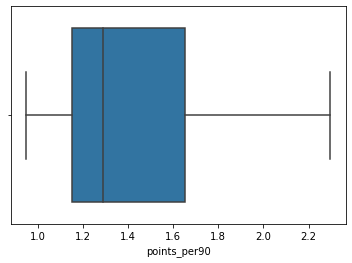

In [18]:
ppg_mean_df = (
    teams_df.groupby(["squad"])[["squad", "points_per90"]]
    .mean()
    .sort_values(by="points_per90", ascending=False)
    .reset_index()
)

sns.boxplot(x=ppg_mean_df["points_per90"])

Cross-category correlation

In [6]:
# Get correlation
teams_corr_df = get_correlation(teams_df, list(teams_df.columns))

# Filter out correlations between similar variables
teams_corr_df = teams_corr_df[
    teams_corr_df.apply(
        lambda row: in_different_category(row['col_1'], row['col_2']),
        axis=1
    )
].reset_index(drop=True)

In [7]:
# Note: the following correlation values are absolute (i.e. |corr|)
# as we are measuring strength of correlationship for now
# KIV: are a few outliers skewing the metrics?

# Strong correlation between passes and carries
# passes_live	carries_distance	0.889320
# passes_into_final_third	carries	0.883365
# passes_pct	carries	0.835825

# Strong correlation between progressive actions and: g/a, possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("progressive", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("progressive", regex=True))
# ]

# Strong correlation between possession and g/a
# teams_corr_df[
#     (
#         (teams_corr_df['col_1'].str.contains("possession", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("x", regex=True))
#     ) | (
#         (teams_corr_df['col_1'].str.contains("x", regex=True)) &
#         (teams_corr_df['col_2'].str.contains("possession", regex=True))
#     )
# ]

# Looking at defensive metrics
# teams_corr_df[
#     (teams_corr_df['col_1'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"])) |
#     (teams_corr_df['col_2'].isin(TEAM_COLUMNS_DICT_COMBINED["defence"]))
# ]

# High press =/= high possession
# teams_corr_df[
#     (teams_corr_df['col_1'].str.contains("tackles_att_3rd", regex=True)) |
#     (teams_corr_df['col_2'].str.contains("tackles_att_3rd", regex=True))
# ]

# Q: Is technical and physical ability mutually exclusive?
# A: Probably not? More direct/long-ball teams may lose more aerial duels and
# have lower overall pass accuracy (because of long balls)
# passes_pct	aerials_lost	0.756948
# passes_pct_short	aerials_won	0.625621